# Dynamic Programming and Reinforcement Learning

## Darmet Ludovic - Titouan Vayer

In [68]:
import random as rd
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import pandas as pd

## Objective

The objective is to formalize and compute the tree cutting problem : Considering a tree growing over time we wan't to define a policy which defines wether we should cut the tree or not.

Some situations may happen : the tree can get sick and the growth of tree is random.

An agent can deal with the tree in two ways : cut it or not. If he cuts the tree he gets a certain amount of rewards, otherwise he pauys for maintaning the tree alive.

We will solve the problem via a MDP modelisation and dynamic programming to solve the MDP.

## Formalisation of the MDP.

### The state space.

To achieve the goal we first define the state space of our MDP.

We call $X$ our state space. It will represent the height of the tree AND the health state of this one. It is define by integers like the following :

- If the tree is sick we set the state to $x=0$

- If the tree is healthy we set the state to $x \in [1,...,H_{max}]$ with $H_{max}$ the maximum height of the tree 


$$X=\left\{ 0,1,2,...,H_{max}\right\} $$

### Growth of the tree

Here we formalize the dynamics under the growth of the tree. The values of the probability may change but for now we consider this dynamic :

- In each iteration the tree can grow of one unit with probability 3/4

- The tree can get sick with probability 1/16

- The tree can grow of two units with probability 1/16

- The tree can stagnate with probability 1/8.


### The rewards

Here we define the value of each rewards. As for the values above it may change but for now we consider the rewards :

- Cost of maintenance : -10
- One unit of wood : 10
- Cost of planting a new tree : -5

### Action space

We will consider a simple action space with two possible actions : if we cut the tree we set the action to 1, otherwise we set the action to 0.

$$A=\left\{ 0,1\right\}$$

We may discuss later of the interest of add another action corresponding to planting a new tree.

### How do we deal with the sickness of the tree ?

In the subject it is written "Whenever a tree is cut (or it is dead), a new tree has to planted". To implement this we have two ways :

- Wether in each policy or action that we'll define we have to pay attention to the health state of the tree and if the tree is sick we cut the tree.

- Otherwise we can implement it as a rule in the Tree object that we will define (see below). More precisly, if the state of the tree is -1 we allways return an action 'cut' (1).

We choosed the first option for the reason that otherwise the draws won't be really random and independant, so we will have to implement this rule for each policy

## Tree class

The Tree class modelise the three and the MDP. It implements several methods :

- get_all_rewards : Returns the dictionnary of all rewards associated with the state and the action at these state ($r(x,\pi(x))$

- tree_sim : simulates one step of the MDP process and return the reward and the state associated.

- simulate_MDP : simulates the MDP for a bunch of actions and updates the state of the tree. Returns all the states and the rewards associated with the simulation.

- plot_MDP : Makes a visualisation for a bunch of actions of the MDP process. It plots on one hand the size of the tree in time and on the other side plots the reward at each step and the cumulative sum of rewards (discounted)

In [158]:
class Tree:
    
    def __init__(self,initSize,H,discount=1/1.05,valueUnitOfWood=10,costOfPlanting=-5
                 ,costOfMaintenance=-10,probaOfSick=1/16,probaOfGrowTwice=1/16,probaOfNotGrow=2/16):
        self.size=initSize
        self.initSize=initSize
        self.Hmax=H
        self.discount=discount
        self.valueUnitOfWood=valueUnitOfWood
        self.costOfPlanting=costOfPlanting
        self.costOfMaintenance=costOfMaintenance
        self.probaOfSick=probaOfSick
        self.probaOfGrowTwice=probaOfGrowTwice
        self.probaOfNotGrow=probaOfNotGrow
        self.probaOfGrowOne=1-(self.probaOfNotGrow+probaOfGrowTwice+probaOfSick)
    

    def get_all_rewards(self):
        R={}
        R[(0,0)]=self.costOfMaintenance
        R[(0,1)]=self.costOfPlanting
        for i in range(1,self.Hmax+1):
            R[(i,0)]=self.costOfMaintenance
            R[(i,1)]=i*self.valueUnitOfWood+self.costOfPlanting 
        return R

        
 
    def tree_sim(self,x,a,verbose=0): # One step
        
        reward=0
        
        if a==1  : # Cutting tree or sick tree
            # the reward is height* the value of one unit of wood - maintenance cost 
            # if the tree is sick it's only maintenance cost
            if x==0:
                reward=self.costOfPlanting
            else:
                reward=x*self.valueUnitOfWood+self.costOfPlanting 
            x=1
        
        else : # Don't cut the tree
            choose=rd.random()

            # Getting sick with prob 1/16
            
            if choose<=(self.probaOfSick) :
                if verbose==1 :
                    print('The tree is falling sick')
                reward=self.costOfMaintenance
                x=0
              
            #  Grow of 2 units with prob 1/16
            
            if choose>self.probaOfSick and choose<=(self.probaOfSick+self.probaOfGrowTwice) :
                if verbose==1 :
                    print('The tree grows of two units')
                
                if x<self.Hmax:
                    x=x+2
                
                reward=self.costOfMaintenance
             
            # Don't grow with prob 1/8
            
            if choose>(self.probaOfSick+self.probaOfGrowTwice) and choose<=(self.probaOfSick+self.probaOfGrowTwice+self.probaOfNotGrow):
                if verbose==1 :
                    print('The tree does not grow')
                    
                reward=self.costOfMaintenance

            # Grow of 1 unit with prob 3/4
            
            if choose>(self.probaOfSick+self.probaOfGrowTwice+self.probaOfNotGrow) and choose<=1 :
                if verbose==1 :
                    print('The tree grows of one unit')
                
                if x<self.Hmax:
                    x=x+1
                
                reward=self.costOfMaintenance


        return reward,x
        
    def simulate_MDP(self,actions,verbose=0): # The whole MDP starting from 1
        
        rewards=[]
        treeSizes=[]
        i=1
        
        if len(actions)==1:
            a=actions[0]
            sim=self.tree_sim(self.size,a,verbose)
            treeSizes=sim[1]
            rewards=sim[0]
            self.size=treeSizes
            
        if len(actions)>1: # only for easy plot
            for a in actions:
                if self.size==0:
                    sim=self.tree_sim(self.size,1,verbose)
                else:
                    sim=self.tree_sim(self.size,a,verbose)
                x=sim[1]
                r=sim[0]*self.discount**(i) # Discounted reward
                self.size=x
                treeSizes.append(x)
                rewards.append(r)
                i=i+1
            
        return rewards,treeSizes
    

        
    def plot_MDP(self,rewards,treeSizes,cumul=True): # Plot cumulative sum of rewards and tree height
            

        plt.figure(figsize=(20,10))
        limit=np.zeros(len(treeSizes))
        plt.subplot(1,2,1)
        plt.plot(treeSizes,color='darkgreen',lw=3)
        plt.plot(limit,color='red',lw=1,alpha=0.8,linestyle='--')
        plt.xlim([0,len(rewards)])
        plt.ylim([-1,max(treeSizes)+1])
        plt.title('Simulation of a growing tree', fontsize=15)
        plt.ylabel('Tree\'s Height', fontsize=10)
        plt.xlabel('time', fontsize=10)
        plt.legend(['Tree size','State sick'])
       
        plt.subplot(1,2,2)
        plt.plot(rewards,'r-')
        if cumul==True:
            plt.plot(np.cumsum(rewards),'b--',lw=2)
        plt.title('Rewards', fontsize=15)
        plt.ylabel('Value of rewards', fontsize=10)
        plt.xlabel('time', fontsize=10)
        #plt.yticks(range(min(np.cumsum(rewards)),max(rewards),3))
        plt.legend(['Reward at each time','Cumulative sum of rewards'])

        plt.show()

### Illustration

Just to make a example, we consider a policy and a tree of height 100, and plot the MDP process thanks to the Tree class.

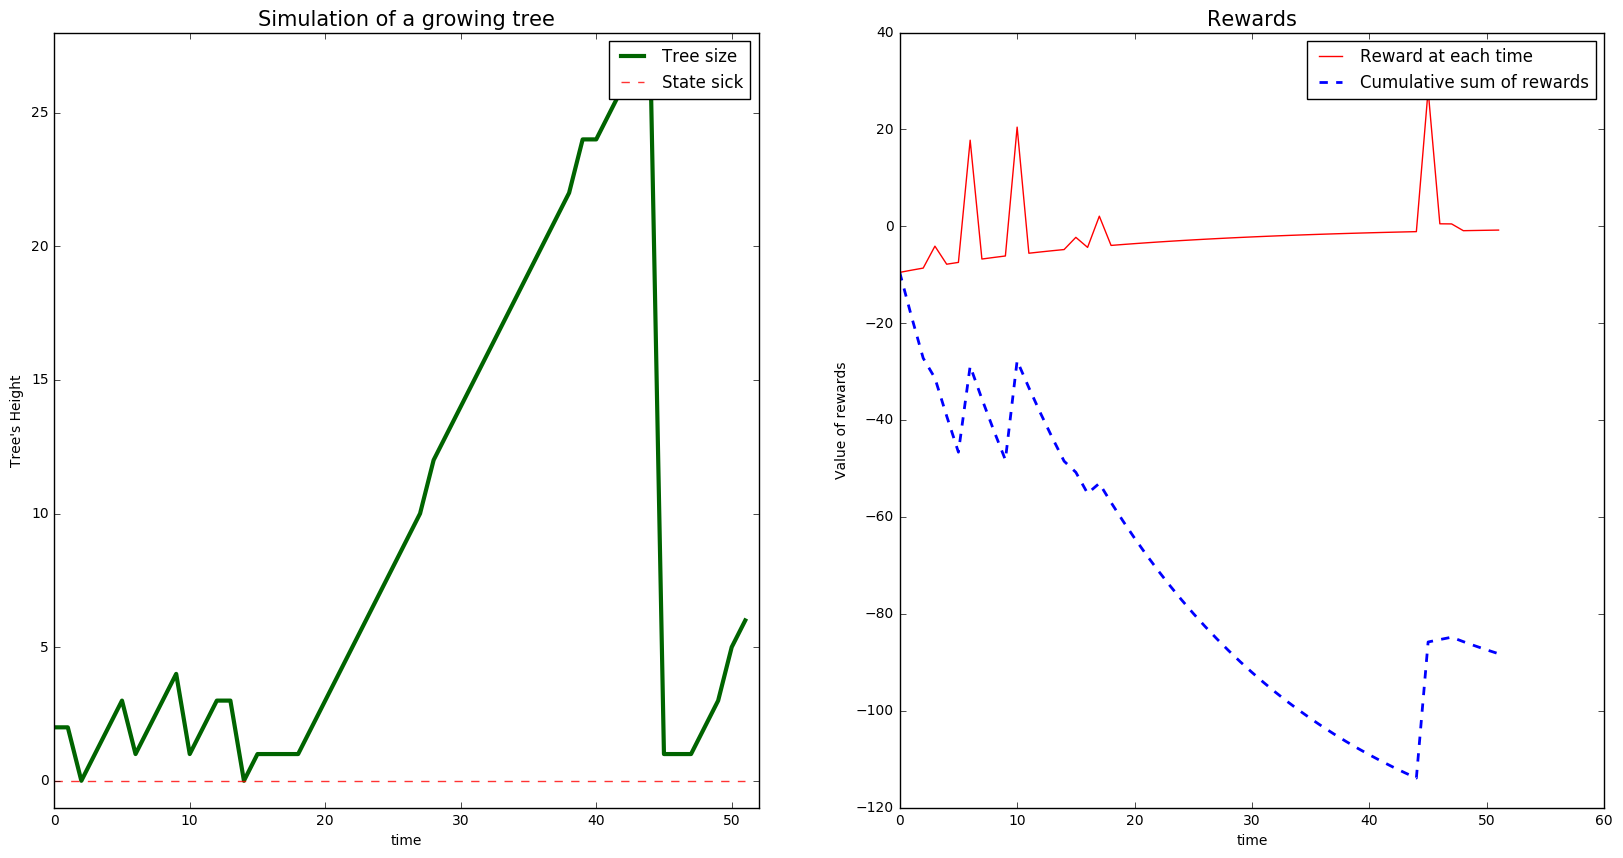

In [160]:
t=Tree(initSize=1,H=100)
actions=[0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0]
rewards,treeSizes=t.simulate_MDP(actions,verbose=0)
t.plot_MDP(rewards,treeSizes)

These two graphs represent a trajectory of our MDP. We see the rewards getting more important (because here they are negative) over the time. And every time the tree is cuted there is an amount of positive rewards except when the tree is sick.

## Compute Matrix  functions.

In order to solve our MDP we need to compute some matrix. We need for example to compute the bellman operator and for that the matrix associated with the bellman equation

$$ V= R+\gamma PV $$

$$ V=(I-\gamma P)^{-1}R $$

which is the matrix $$(p(y|x,\pi(x)))_{(y,x) \in X^{2}}$$

More precisly, when $\pi(x)=0$ (we don't cut) we have the transitions which follows the matrix $P1$  :

$$P1=
\begin{pmatrix}
   0 & 0 & \ldots & \ldots & \ldots & \ldots  & 0 \\
   1/16 & 2/16 & 12/16 & 1/16 & 0 & \ldots  & 0 \\
   1/16 & 0 & 2/16 & 12/16 & \ddots & \ldots & 0 \\
   1/16 & 0 & 0 & 2/16 & \ddots & \ddots  & 0 \\
   \vdots & \vdots & \vdots & 0 & \ddots & \ddots & 1/16\\
   \vdots & \vdots & \vdots & \vdots & \ddots & \ddots & 12/16\\
   1/16 & 0 & 0 & 0 & 0 & 0 & 2/16\\
\end{pmatrix}$$

The index of the row is $y$ and of the column is $x$. Our first row reprents the situation 'the tree is sick and we move to the next state'. But in our modelisation when we are sick $\pi(x)=1$ for sure ! (because we hard written it), so we won't ever take the first row of the matrix.

When $\pi(x)=1$ (when we cut) we have :

$$P2=
\begin{pmatrix}
   0 &1 & 0 & \ldots & 0  \\
   0 & 1 & 0 & \ldots & 0 \\
   \vdots & \vdots & \vdots & \ldots & \vdots \\
   0& 1 & 0 &\ldots & 0   
\end{pmatrix}$$

Indeed when we cut we always go to the state one with probability one.

Each of these matrix is $H_{max}*H_{max}$

To find the $P$ matrix of the bellman equation we need these two matrix because the $P$ matrix will be a mixed of the two previous matrix : when we cut the tree we will choose the row associated with the P2 matrix and otherwise we take we choose the row associated with the current state one the matrix P1.
   

In [161]:
def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)

def computePQ(H):
    a=np.zeros(H)+2/16
    b=np.zeros(H-1)+12/16
    c=np.zeros(H-2)+1/16
    e=np.zeros(H)+1/16
    e[0]=3/16
    P=tridiag(a, b, c,k1=0,k2=1,k3=2)
    P[:,0]=e
    Q=np.zeros((H,H))
    Q[:,0]=np.ones(H)
    return P,Q

def inv(P,discount):
    I=np.eye(len(P))
    M1=(I-discount*P)
    Pinv=np.linalg.inv(M1)
    return Pinv

## The agents

Agents follow a policy and compute it's value.
The value is computed using Monte-Carlo methods, Bellman iterative computation, and Bellman direct computation.

The Agent class implement those following methods :

- policy : This is the method who will implement the policy of the agent

- simul_policy : simulates the policy. We can do it several times and return the average results 

- plot_policy : Plot the policy 

- tree_MDP : It is the method which returns all the MDP process' characterics : the vector of the rewards in each state according to the policy $r(x,\pi(x))$ and the transition matrix $(p(y|x,\pi(x)))_{(y,x) \in X^{2}}$ according to the policy.

- bellman_op : computes the bellman operator for a given vector

- ev_policy_iterative_computation : evaluates the policy by iterative computation of the bellman operator

- ev_policy_direct_computation : evaluates the policy by inversing the bellman equation

- ev_policy_motecarlo : evaluates the policy by monte carlo method 

In [174]:
class Agent() :
    
    def __init__(self):
        self.name='agent'
        
    def policy(self,x): # Each agent implement is own policy
        raise NotImplementedError("Dumb ass ! Please implement this method") 
        
    def simul_policy(self,horizon,tree,nbRuns=1): # Mean rewards and three height for a given policy on multiple runs
        rewards=np.zeros((horizon,nbRuns))
        rewards_undiscounted=np.zeros((horizon,nbRuns))
        treeSizes=np.zeros((horizon,nbRuns))

        for run in range(nbRuns):
            t=Tree(initSize=tree.initSize
            ,costOfMaintenance=tree.costOfMaintenance
            ,costOfPlanting=tree.costOfPlanting
            ,H=tree.Hmax
            ,valueUnitOfWood=tree.valueUnitOfWood)
            
            for i in range(horizon):
                a=self.policy(t.size)            
                res=t.simulate_MDP([a])
                rewards[i,run]=res[0]*tree.discount**(i)
                rewards_undiscounted[i,run]=res[0]
                treeSizes[i,run]=res[1]
                    
        if nbRuns==1:
            return rewards,rewards_undiscounted,treeSizes
        else:
            return np.mean(rewards,axis=1),np.mean(treeSizes,axis=1)
        
    def plot_policy(self,horizon,nbRuns,tree): # Plot rewards and three heigth evolution
        rewards,rewards_un,treeSizes=self.simul_policy(nbRuns=nbRuns,horizon=horizon,tree=tree)
        tree.plot_MDP(rewards,treeSizes)
    
    # Compute P and R of the Bellman equation for a given policy
    def tree_MDP(self,tree):
        rewards_dic=tree.get_all_rewards()
        P1,P2=computePQ(H=tree.Hmax+1)
        P=np.zeros((tree.Hmax+1,tree.Hmax+1))
        R=[]
        
        
        for i in list(range(0,tree.Hmax+1)): # Return all state
            R.append(rewards_dic[(i,self.policy(i))])
            
            # Dead tree : this case is handled in the first row
            if i==0:
                P[0,:]=P2[0,:]
            else:
                if self.policy(i)==0:
                    P[i,:]=P1[i,:]
                if self.policy(i)==1:
                    P[i,:]=P2[i,:]
        return P,R
        
    def bellman_op(self,tree,v): # Bellman operator
        P,R=self.tree_MDP(tree)
        
        return R+tree.discount*np.dot(P,v)
    
    def ev_policy_iterative_computation(self,tree,nIter): # Bellman iterative computation
        V=np.zeros(tree.Hmax+1)
        
        for i in range(nIter):
            V=self.bellman_op(tree,V)
        
        return V
        
    def ev_policy_direct_computation(self,tree): # Bellman direct computation
        
        P,R=self.tree_MDP(tree)
        
        Pinv=inv(P,discount=tree.discount)
        V=np.dot(Pinv,R)
        
        return V
    
    def ev_policy_motecarlo(self,tree,horizon,nbRuns,states):  # Every visit Monte-Carlo simulation
        rewards=np.zeros((horizon,nbRuns))
        treeSizes=np.zeros((horizon,nbRuns))
        V=[]
        
        # For each defined state 
        for x in states:
            
            rewards_trajectory=[]
            # Simulate trajectories starting from a specific state
            for run in range(nbRuns):
                
                # Compute a tree with height x
                t=Tree(initSize=x                     
                ,costOfMaintenance=tree.costOfMaintenance
                ,costOfPlanting=tree.costOfPlanting
                ,H=tree.Hmax
                ,valueUnitOfWood=tree.valueUnitOfWood)
            
                # Explore following state
                rewards=[]
                for i in range(horizon):
                    a=self.policy(t.size)
                    res=t.simulate_MDP([a])
                    rewards.append(res[0]*(tree.discount**i))

                    
                rewards_trajectory.append(np.sum(rewards))
                print(rewards_trajectory)
            V.append(np.mean(rewards_trajectory))
    
        return V
        


### Arbitrary Agent

We now define an arbitrary agent who fillows an abitrary policy. The agent follows the rule : "hum Ok if the tree is higher than 10 cut it !". 

With this agent we will evaluate the policy with three methods : monte carlo, bellman direct and bellman iterative.

In [175]:
class ArbitraryAgent(Agent): # Inherit from Agent class
    
    def __init__(self,cut=10):
        Agent.__init__(self)
        self.cut=cut
     
    # Simple policy : cut only if the three grow above a given limit
    def policy(self,x):
        if x==0: # hard written rule
            return 1
        else :
            if x>=self.cut:
                return 1
            else:
                return 0

### Illustration

We set a tree to 15 and a cutting parameter to 5. We run one time the policy for a horizon of 80.

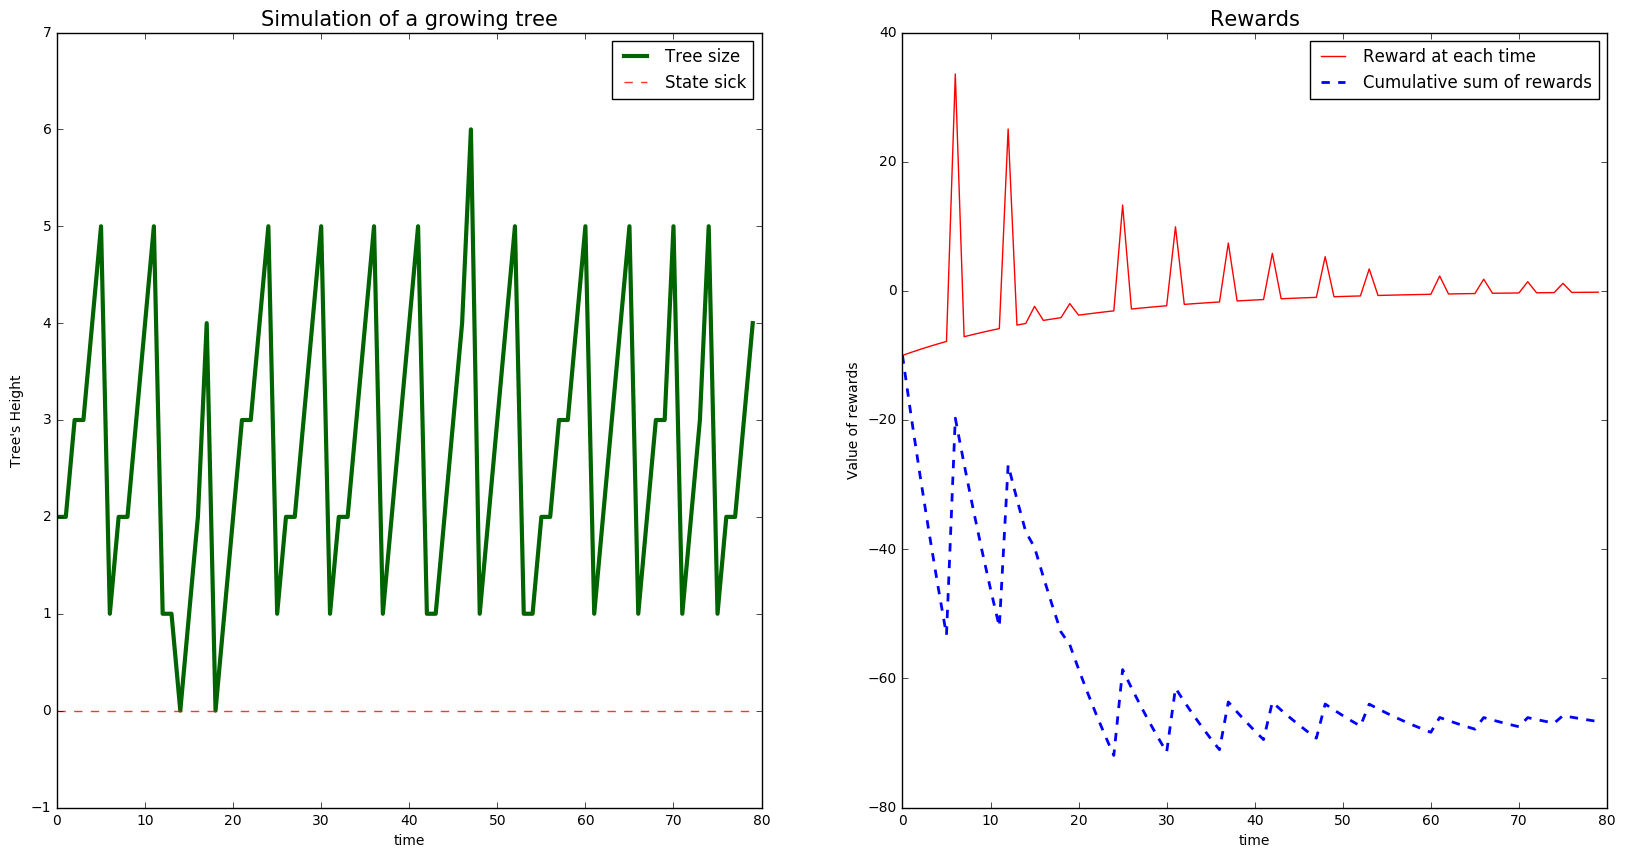

In [176]:
t=Tree(initSize=1,H=15)
arbA=ArbitraryAgent(cut=5)
arbA.plot_policy(horizon=80,nbRuns=1,tree=t)

It illustrates the policy : when the tree is higher than 10 the tree is cuted and a certain amount of rewards is returned.

### Policy evaluation : direct computation

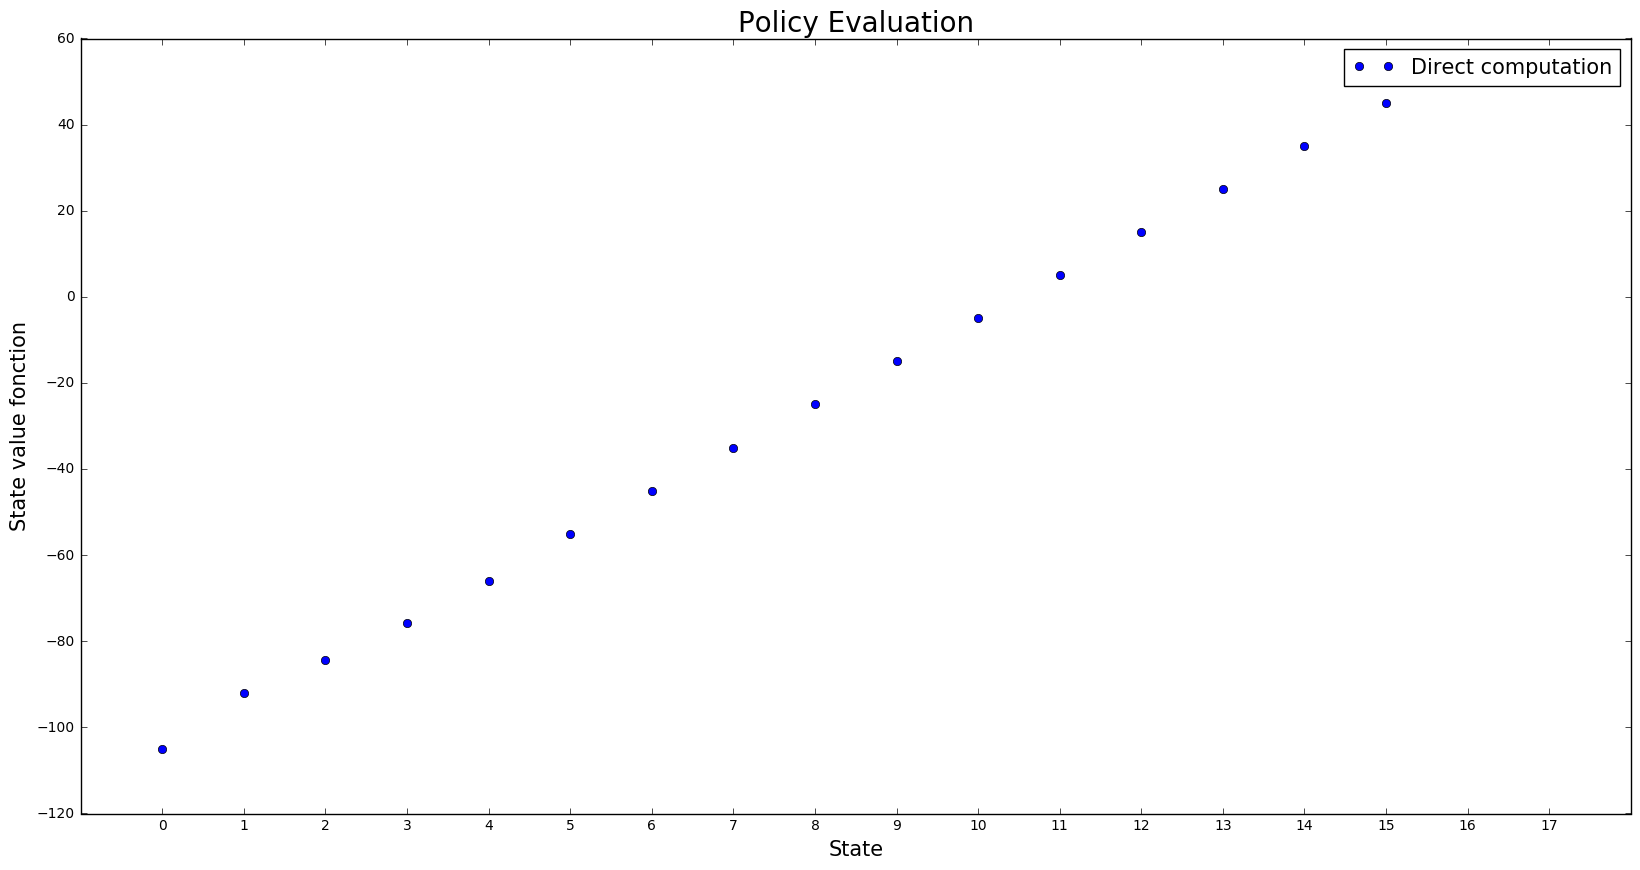

In [165]:
t=Tree(initSize=1,H=15)
arbA=ArbitraryAgent(cut=5)
Vdirect=arbA.ev_policy_direct_computation(t)
plt.figure(figsize=(20,10))
plt.plot(Vdirect,'bo')
plt.title('Policy Evaluation',fontsize=20)
plt.xlabel('State',fontsize=15)
plt.ylabel('State value fonction',fontsize=15)
plt.legend(['Direct computation'],fontsize=15)
plt.xticks(range(18))
plt.xlim([-1,18])
plt.show()

We see on this graph that the state sick is the less rewarding state according to this policy. Indeed we can't get any good reward in this state because the tree is sick and has no value. After the states getting better and better due to the fact that the more the tree is high the more rewarding it is when we cut it. 

We can also guess a king of break after the state 5, the curve seems to increase faster, and it is due to the fact that with our policy the states after 5 are more rewarding than the others.

### Case of another policy

Juste to make another example of the previous result we compute another agent that only cut if the tree is equal to 2 otherwise he never cuts and we will increase the amount of rewards for each unit of wood.

In [166]:
class RandomAgent(Agent): # Inherit from Agent class
    
    def __init__(self,cut=2):
        Agent.__init__(self)
        self.cut=cut
     
    def policy(self,x):
        
        if x==0: # hard written rule
            return 1
        else :
            if x==self.cut:
                return 1
            else:
                return 0

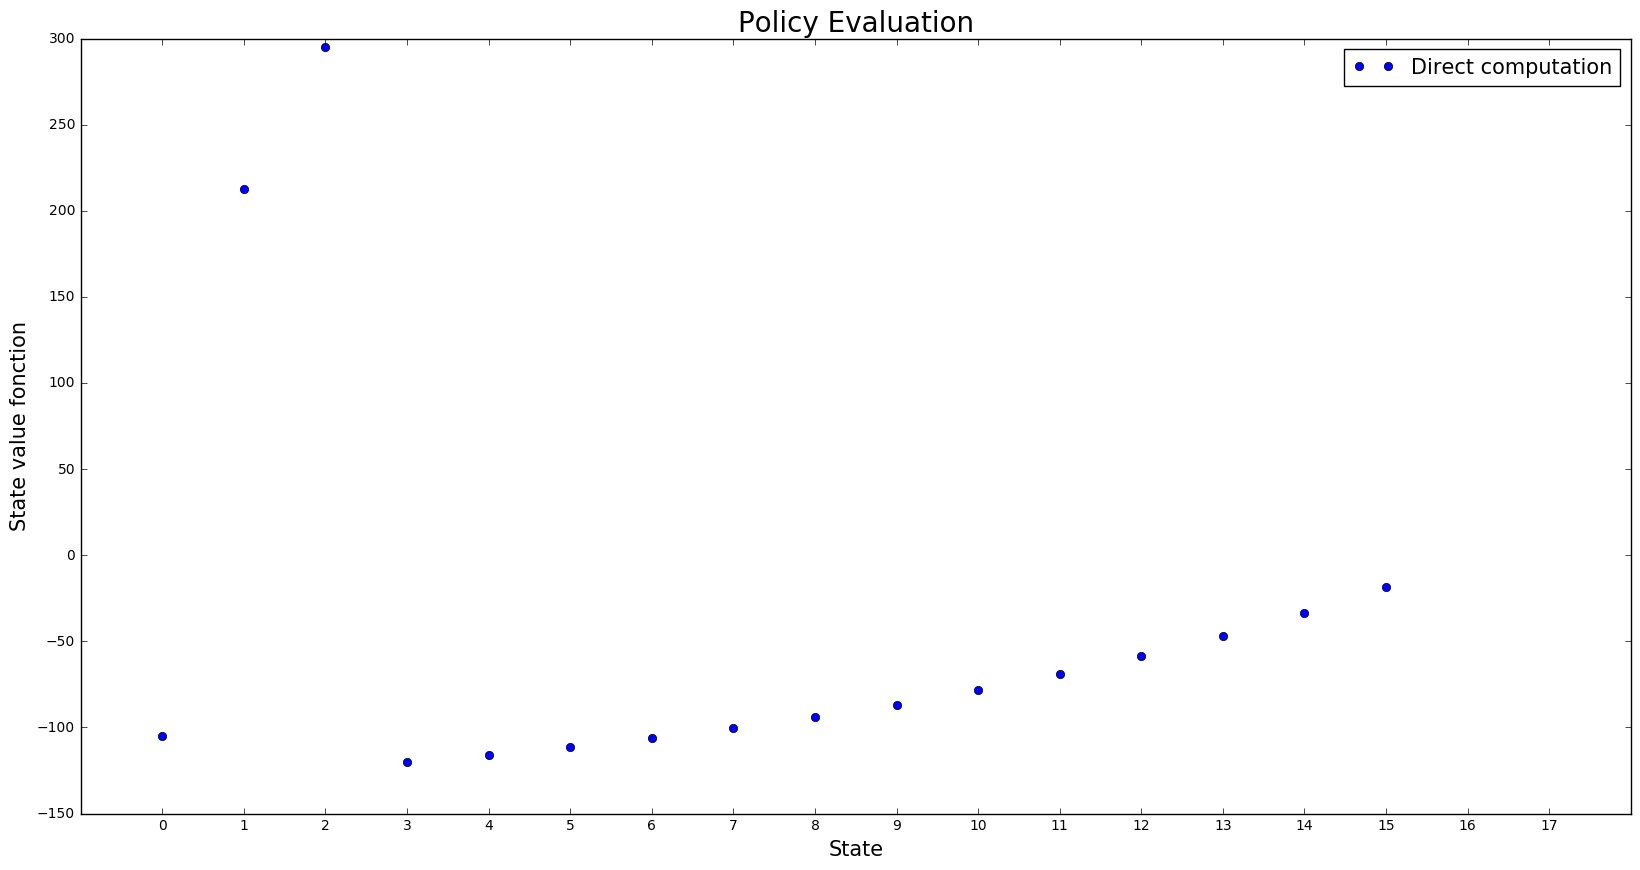

In [167]:
t=Tree(initSize=1,H=15,valueUnitOfWood=200)
rA=RandomAgent(2)
Vdirect=rA.ev_policy_direct_computation(t)
plt.figure(figsize=(20,10))
plt.plot(Vdirect,'bo')
plt.title('Policy Evaluation',fontsize=20)
plt.xlabel('State',fontsize=15)
plt.ylabel('State value fonction',fontsize=15)
plt.legend(['Direct computation'],fontsize=15)
plt.xticks(range(18))
plt.xlim([-1,18])
plt.show()

It is more clear here that the state 2 has a particularity. Also the state one because it is the more probable state from where we came from to reach 2.

### Interative Bellman convergence

Let's get back to the first agent who cut in 5.

We will illustrate the iterative bellman convergence by plotting the sum of squared error in each iteration with the direct computation in all state and by plotting also $\|V_{n}(x_{0})-V^{*}(x_{0})\|$ over itertion $n$. $V^{*}(x_{0})$ is cumputed by direct computation by resolving the bellman equation.

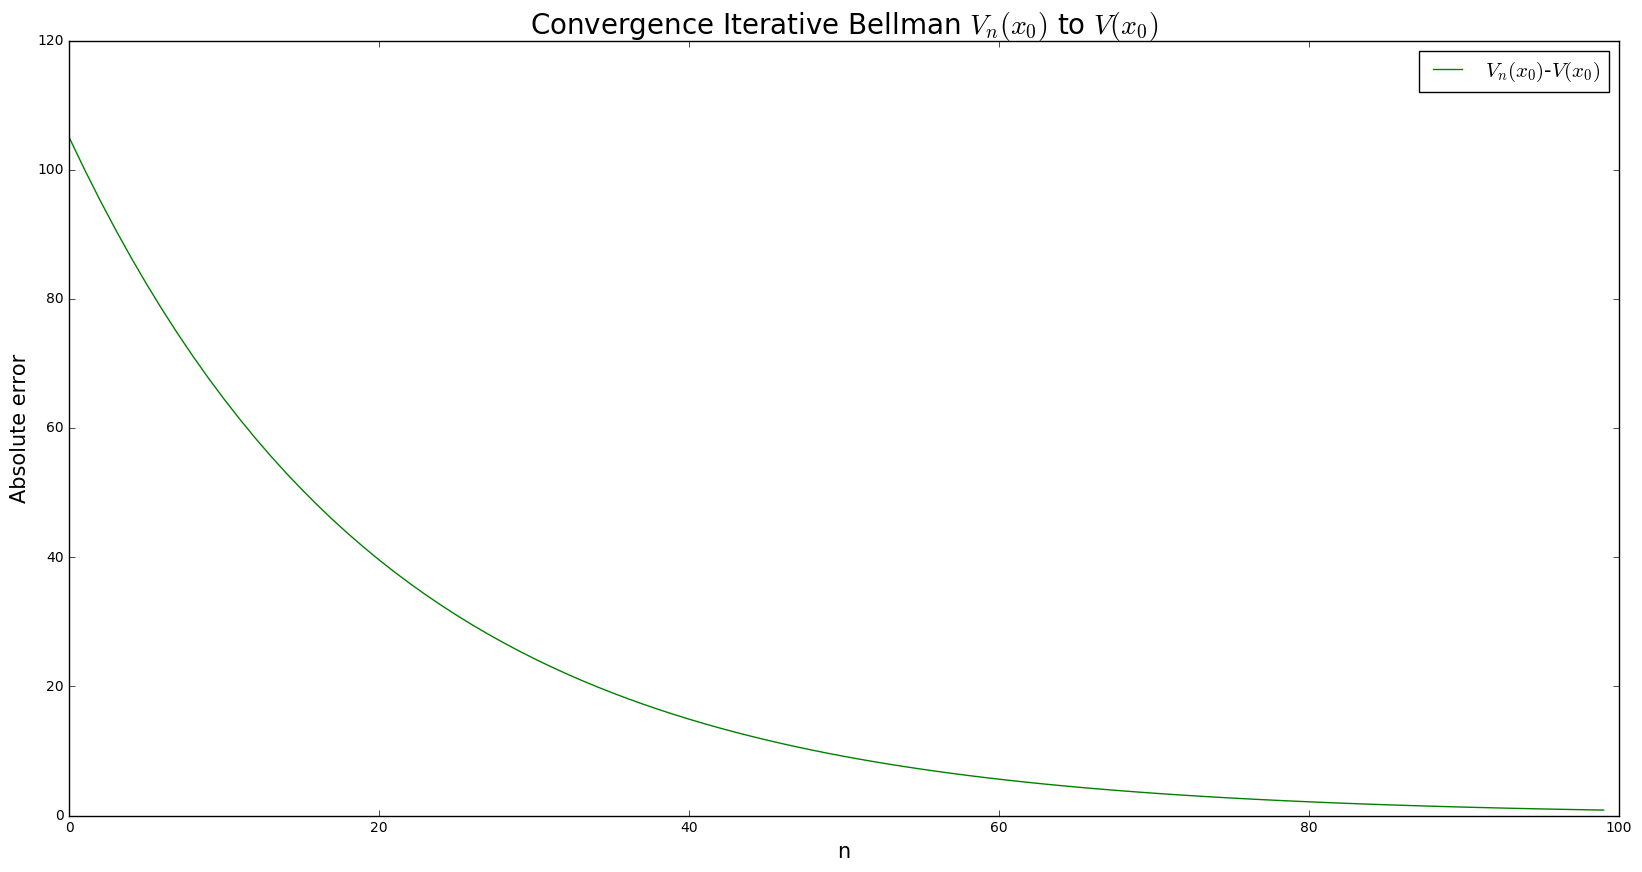

In [168]:
Vdirect=arbA.ev_policy_direct_computation(t)[0]
error=[]
for i in range(100):
    Vinte=arbA.ev_policy_iterative_computation(t,i)[0]
    error.append(abs(np.array(Vinte)-np.array(Vdirect)))
    
plt.figure(figsize=(20,10))
plt.plot(error,'g-')
plt.title('Convergence Iterative Bellman $V_{n}(x_{0})$ to $V(x_{0})$',fontsize=20)
plt.xlabel('n',fontsize=15)
plt.ylabel('Absolute error',fontsize=15)
plt.legend(['$V_{n}(x_{0})$-$V(x_{0})$'],fontsize=15)
plt.show()

As we can see in the above result, $\|V_{n}(x_{0})-V(x_{0})\|$ does converge and we can also see that the shape is look like the theory which state that $\|V_{n+1}(x_{0})-V(x_{0})\| \leq \gamma^{n+1}\|V_{0}(x_{0})-V^{*}(x_{0})\|$. We can guess this geometric decreasing.

We can also plot for all the states the following:

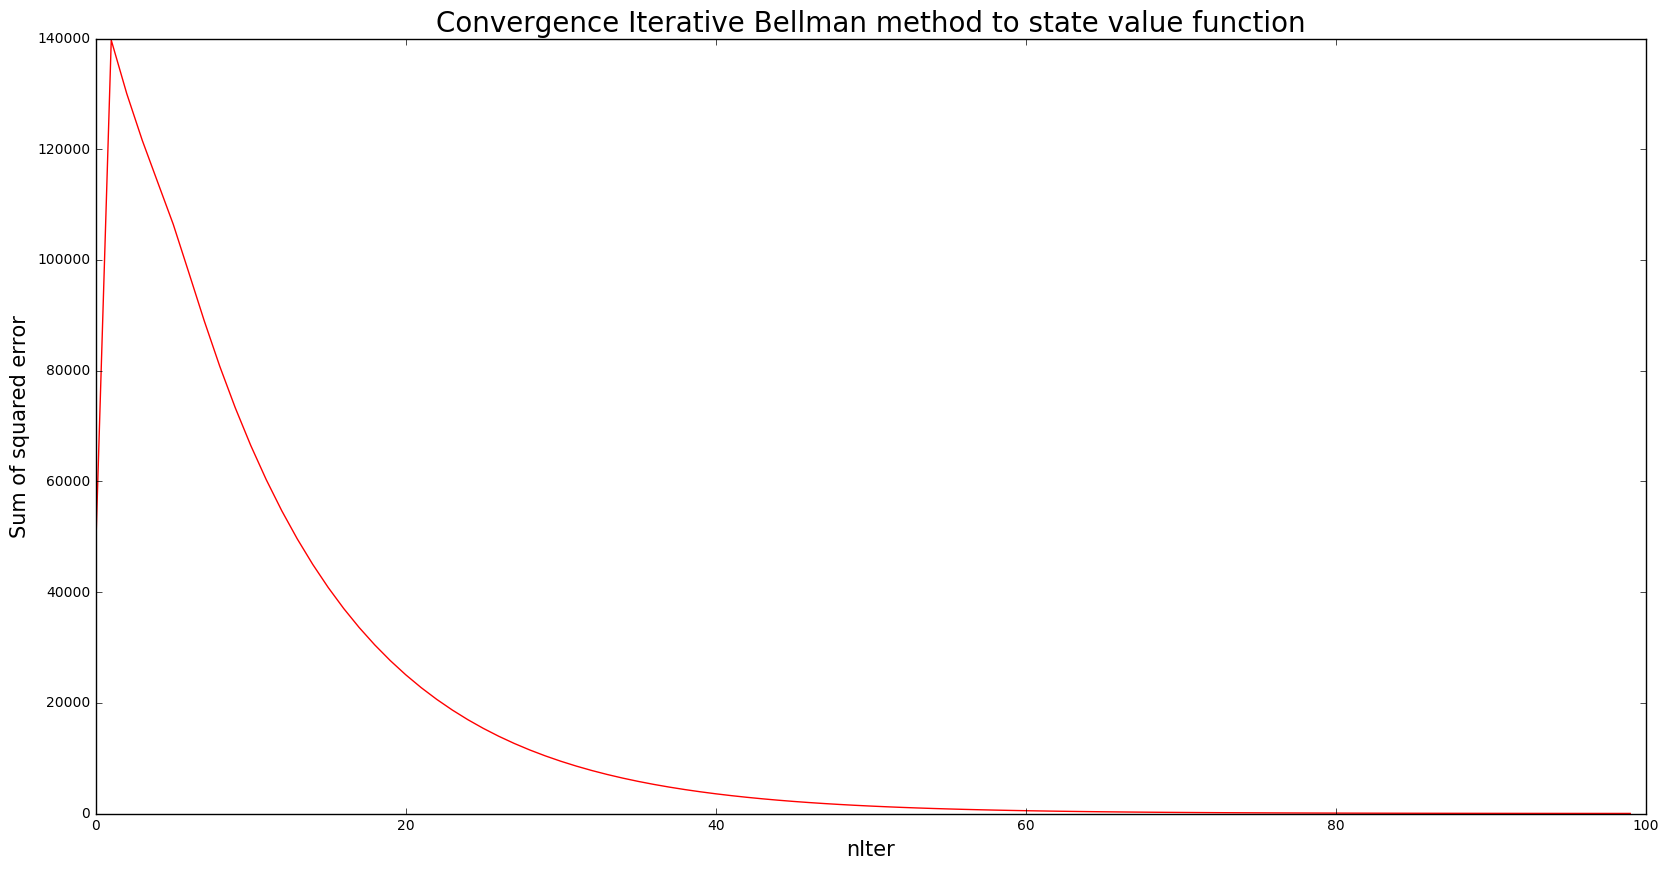

In [171]:
Vdirect=arbA.ev_policy_direct_computation(t)
error=[]
for i in range(100):
    Vinte=arbA.ev_policy_iterative_computation(t,i)
    error.append(np.sum(abs(np.array(Vinte)-np.array(Vdirect))**2))
    
plt.figure(figsize=(20,10))
plt.plot(error,'r-')
plt.title('Convergence Iterative Bellman method to state value function',fontsize=20)
plt.xlabel('nIter',fontsize=15)
plt.ylabel('Sum of squared error',fontsize=15)
plt.show()

We get as well the convergence with the same shape. We can also plot for another tree with a discount higher w

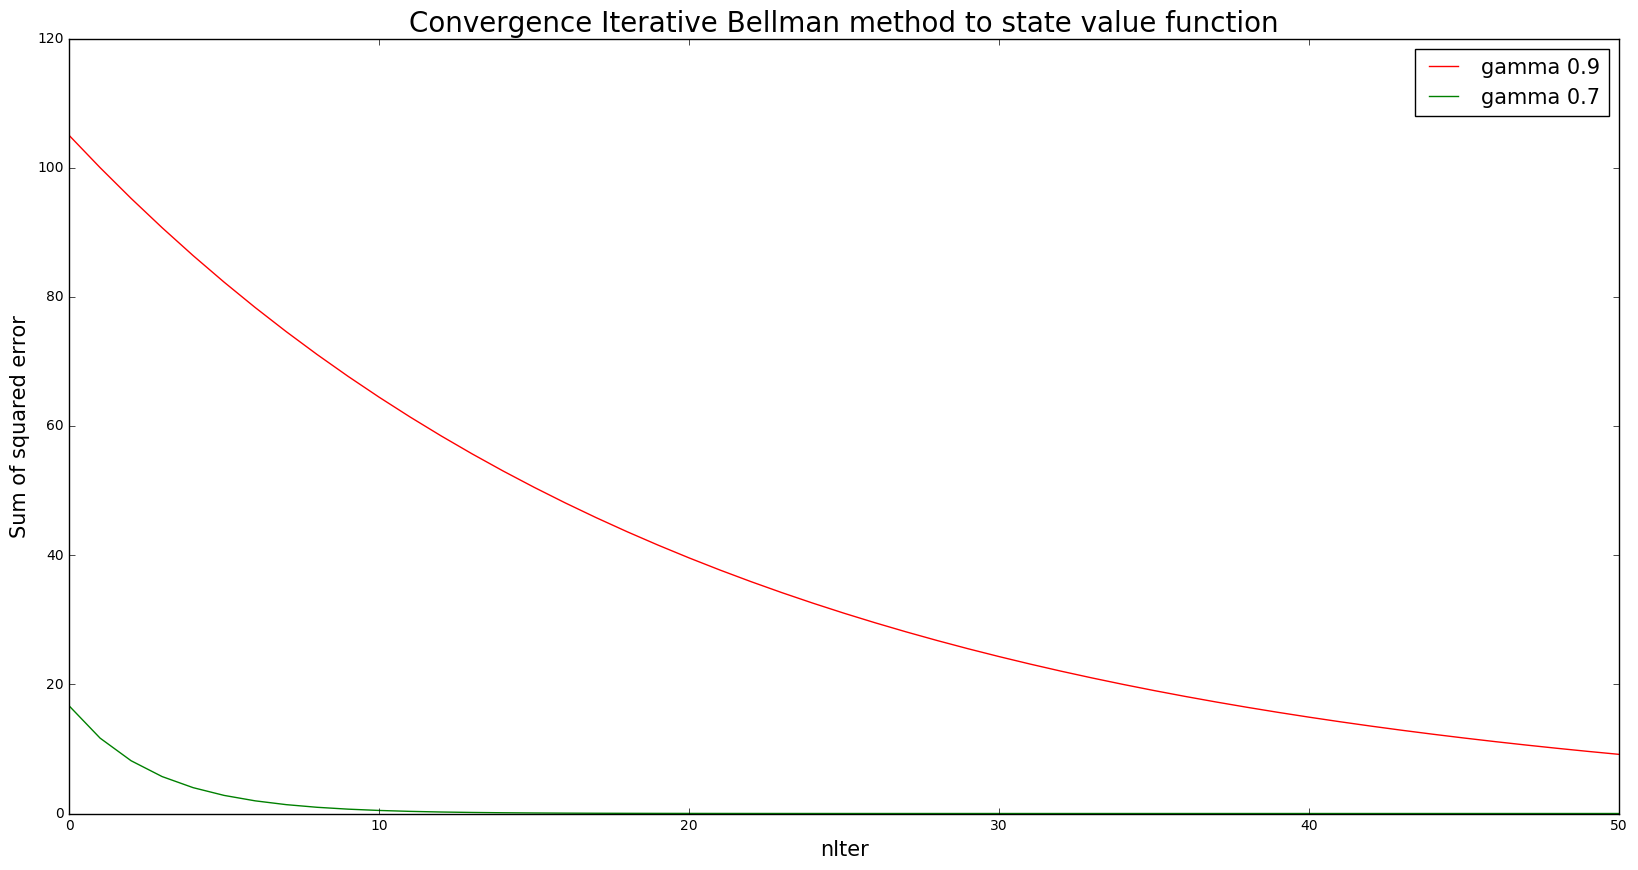

In [170]:
t=Tree(initSize=1,H=15)
t2=Tree(initSize=1,H=15,discount=0.7)
Vdirect=arbA.ev_policy_direct_computation(t)[0]
Vdirect2=arbA.ev_policy_direct_computation(t2)[0]
error2=[]
error=[]
for i in range(100):
    Vinte=arbA.ev_policy_iterative_computation(t,i)[0]
    Vinte2=arbA.ev_policy_iterative_computation(t2,i)[0]
    error.append(abs(np.array(Vinte)-np.array(Vdirect)))
    error2.append(abs(np.array(Vinte2)-np.array(Vdirect2)))

plt.figure(figsize=(20,10))
plt.plot(error,'r-')
plt.plot(error2,'g-')
plt.title('Convergence Iterative Bellman method to state value function',fontsize=20)
plt.xlabel('nIter',fontsize=15)
plt.legend(['gamma 0.9','gamma 0.7'],fontsize=15)
plt.ylabel('Sum of squared error',fontsize=15)
plt.xlim([0,50])
plt.show()

As we can see the one with the highest gamma is converging faster because of the $\gamma^{n+1}$

### Monte Carlo convergence


In this part we will ilustrate the monte carlo method to estimate the state value fonction. 

In [ ]:
t=Tree(initSize=1,H=15)
arbA=ArbitraryAgent(cut=5)
Vdirect=arbA.ev_policy_direct_computation(t)[1]
error=[]
v=[]
for i in range(500):
    #if (i//10)*10-i==0:
        #print(i)
    Vmonte=arbA.ev_policy_motecarlo(t,horizon=100,nbRuns=i,states=[1])
    error.append(abs(np.array(Vmonte)-np.array(Vdirect)))


//anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


[-20.537622444245883]
[-41.272197098744435]
[-41.272197098744435, -40.956265249123575]
[-24.576247403741775]
[-24.576247403741775, -28.563256161631877]
[-24.576247403741775, -28.563256161631877, -41.855331318224053]
[-58.323572119245767]
[-58.323572119245767, -108.1371007300322]
[-58.323572119245767, -108.1371007300322, -61.308823616900376]
[-58.323572119245767, -108.1371007300322, -61.308823616900376, -69.632868918575852]
[-34.426027173363103]
[-34.426027173363103, -28.239772100770669]
[-34.426027173363103, -28.239772100770669, -75.131331664354619]
[-34.426027173363103, -28.239772100770669, -75.131331664354619, -19.217597382871507]
[-34.426027173363103, -28.239772100770669, -75.131331664354619, -19.217597382871507, -22.03674149084161]
[-30.269432140611251]
[-30.269432140611251, -5.8897555774658263]
[-30.269432140611251, -5.8897555774658263, -21.428824540992476]
[-30.269432140611251, -5.8897555774658263, -21.428824540992476, -39.910603963420918]
[-30.269432140611251, -5.889755577465826

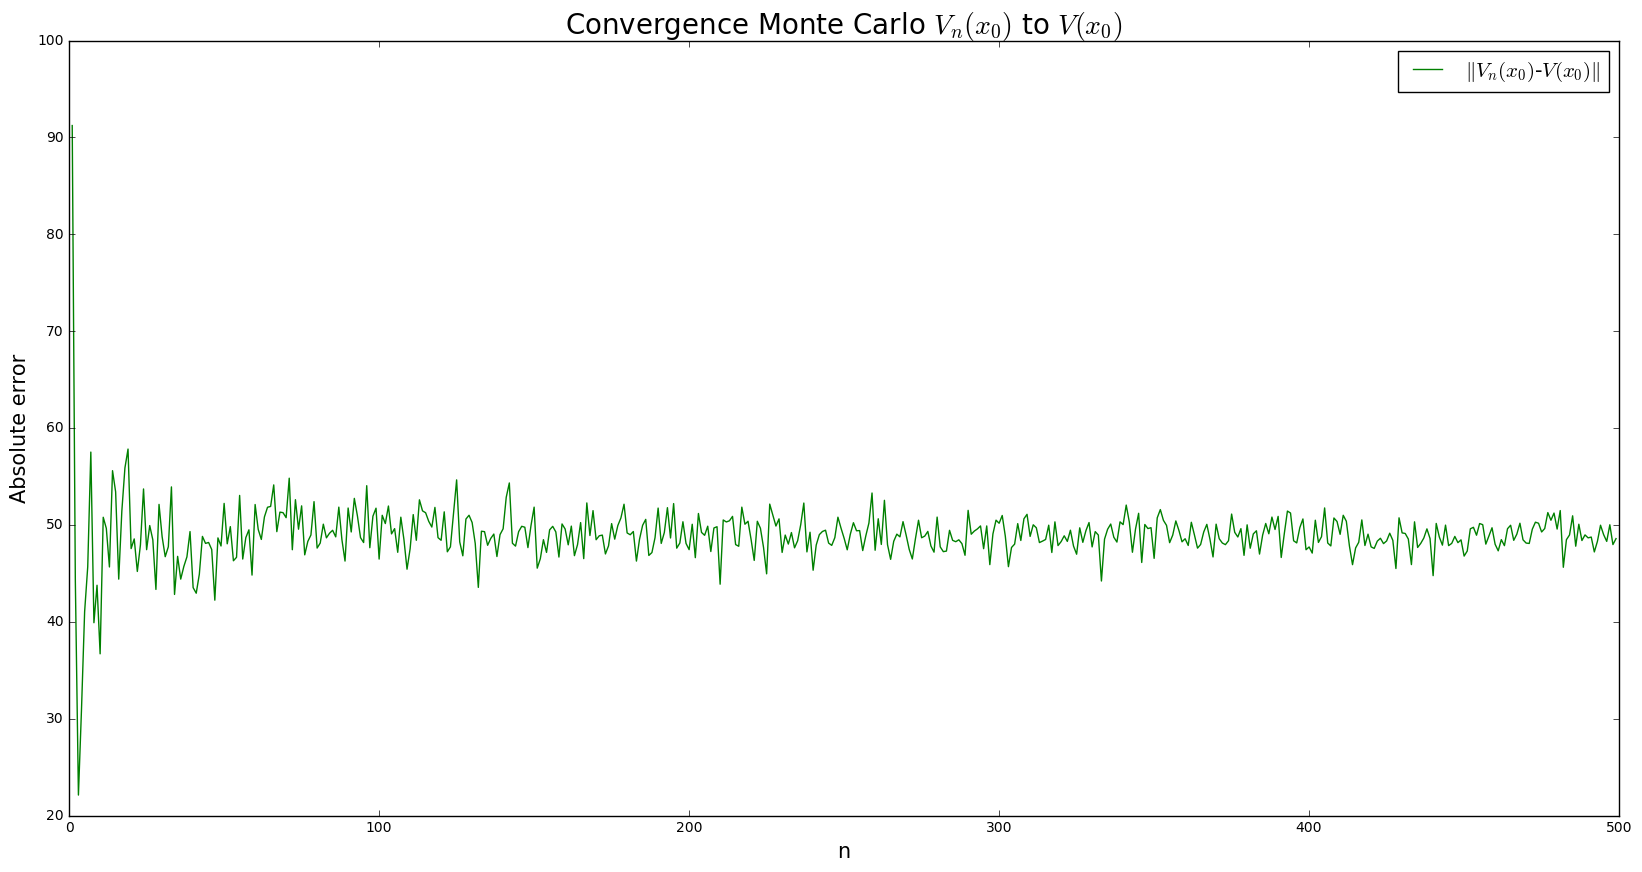

In [177]:
plt.figure(figsize=(20,10))
plt.plot(error,'g-')
#plt.plot(Vmonte,'r-')
plt.title('Convergence Monte Carlo $V_{n}(x_{0})$ to $V(x_{0})$',fontsize=20)
plt.xlabel('n',fontsize=15)
plt.ylabel('Absolute error',fontsize=15)
plt.legend(['$\|V_{n}(x_{0})$-$V(x_{0})\|$'],fontsize=15)
plt.show()

In [12]:
Vdirect=arbA.ev_policy_direct_computation(t)
error=[]
for i in range(40):
    #print(i)
    Vmonte=arbA.ev_policy_motecarlo(t,horizon=100,nbRuns=i)
    error.append(np.sum(abs(np.array(Vmonte)-np.array(Vdirect))**2))

TypeError: ev_policy_motecarlo() missing 1 required positional argument: 'states'

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(error,'r-')
plt.title('Convergence Monte Carlo to state value function',fontsize=20)
plt.xlabel('nIter',fontsize=15)
plt.ylabel('Sum of squared error',fontsize=15)
plt.show()

We see that the error is quite big : maybe this is due to the fact that we cut the horizon to 100. By increasing the horizon we may get a better result.

### Policy Evaluation Illustration

In [ ]:
Vdirect=arbA.ev_policy_direct_computation(t)
Vmonte=arbA.ev_policy_motecarlo(t,horizon=1000,nbRuns=2000,states=[-1]+list(range(1,t.Hmax+1)))
Vinte=arbA.ev_policy_iterative_computation(t,50)
plt.figure(figsize=(20,10))
plt.plot(Vdirect,'bo')
plt.plot(Vmonte,'ro')
plt.plot(Vinte,'g--',lw=3,alpha=0.8)
plt.title('Policy Evaluation',fontsize=20)
plt.xlabel('State',fontsize=15)
plt.ylabel('State value fonction',fontsize=15)
plt.legend(['Direct computation','Monte carlo computation','Iterative method'],fontsize=15)
plt.show()

## Learning Agent

In [13]:
class LearningAgent(Agent): # Inherit from Agent class
    
    def __init__(self,pi,tree):
        Agent.__init__(self)
        if len(pi) != tree.Hmax+1:
            print('State length and tree must have the same size !')
        else :
            self.pi = pi
     
    # Simple policy : cut only if the three grow above a given limit
    def policy(self,x):
        return self.pi[x-1]

In [66]:
H=10
pi = [0,0,0,0,0,0,0,0,0,0,0]
if len(pi)>H+1:
    print('Too much actions !')
Q = np.zeros((H,2))
epsilon = 0.01

# Apply our policy on H*100 iters
t=Tree(initSize=1,H=H)
lerA = LearningAgent(pi=pi,tree=t)

rewards, threeHeight = lerA.simul_policy(nIter=500,tree=t)
for j in range(len(threeHeight)-1):

    state = int(threeHeight[j])-1 #three height at current state
    reward = rewards[state] # reward at current state
    action = pi[state] # action take at current state
    next_state = int(threeHeight[j+1])-1 #three heigh at next state

    deltaT = reward + t.discount*(Q[next_state,np.argmax(Q[next_state,:])])-Q[state,action]
    Q[state,action]= Q[state,action] + 1/(j+1)*deltaT # Q update
    #print('a')
    for l in range(len(Q)):
        if rd.random() > epsilon:
            pi[l] = np.argmax(Q[l,:],axis=0)
        else:
            pi[l] = np.argmin(Q[l,:],axis=0) 


IndexError: index 10 is out of bounds for axis 0 with size 10

In [67]:
pi

[1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0]

In [65]:
Q

array([[-2.06595966, -2.0838525 ],
       [-9.52380952, -2.83007292],
       [-4.53514739, -2.35681062],
       [-2.87945866, -1.03015897],
       [-2.05675619, -0.62933155],
       [-1.56705233, -0.7472475 ],
       [-2.13204399, -0.89954187],
       [-0.37922792, -0.36536199],
       [-0.33697545, -0.32649661],
       [-6.89622339, -6.89620148]])